# Understanding Volatility Movements  

## Introduction

For our next application of neural networks, some extra background  about derivatives is required.  The Black−Scholes−Merton model relates an option price to the asset price, strike price, dividend yield, riskfree interest rate, time to maturity, and volatility. All of these quantities  are known by analysts except volatility. This means that the Black−Scholes−Merton model in effect provides a one-to-one mapping  of volatility to the price of an option. The volatility that gives the market  price of an option is known as the implied volatility. The moneyness of an option is a measure of how likely an option is to  be exercised. One measure of the moneyness of an option that is frequently used by traders is delta. This is the sensitivity of the option’s  price to the price of the underlying asset. For the Black−Scholes−Merton  model given earlier, the delta of a call option is $𝑒^{−𝑞𝑇𝑁(𝑑_1)}$. For a call  option that is highly unlikely to be exercised (high strike price), delta is  close to zero. As the option become more likely to be exercised (i.e., the  strike price is reduced), delta increases. When the option is almost certain to be exercised delta is close to one.  The volatility surface gives the implied volatility as a function of the  moneyness and time to maturity. If Black−Scholes−Merton was a perfect model for the pricing of options in the market, the implied volatilities for all options would be the same and would never change. In practice, the model is far from perfect and the volatility surface is used by  analysts to monitor the market.  

Many different non-linear  shapes for the surface are observed in practice. When the price of an  asset declines, all implied volatilities calculated from options on the asset tend to increase, and vice versa. However, the implied volatilities do  not all change by the same amount. This leads to many variations in the  pattern of implied volatilities.  Understanding how the volatility surface moves is important for a  number of reasons:

- It can help a trader hedge exposures more precisely 

- It can help a quant determine a more sophisticated model reflecting how options are priced by the market.  

- It can help a trader adjust implied volatilities in a market where  asset prices are changing fast. 

A neural network is a natural tool for using empirical data to model volatility surface movements. We will illustrate how it can be used in what  follows. 

In [21]:
#This program takes about 60 minutes to run
#Loading Package
import os

import time
import numpy as np
import scipy as sci
import scipy.io as sio
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras


from numpy.random import seed
seed(100)


import matplotlib.pyplot as plt
from IPython.display import clear_output


## The Dataset

Our data consists of call options on the S&P 500 between 2014 and  2019.

In [22]:
# load raw data
DATA_FOLDER = './data'
FILE_NAME   = 'Implied_Volatility_Data_vFinal.csv'
raw = pd.read_csv(os.path.join(DATA_FOLDER, FILE_NAME))
# check the raw data
print("Size of the dataset (row, col): ", raw.shape)
raw.head(n=5)

Size of the dataset (row, col):  (125700, 5)


,Date,SPX Return,Time to Maturity in Year,Delta,Implied Volatility Change
0,20140630,0.006678,0.184,0.745927,0.008462
1,20140630,0.006678,2.252,0.286911,0.002024
2,20140630,0.006678,0.124,0.902941,0.019707
3,20140630,0.006678,2.144,0.910926,0.006424
4,20140630,0.006678,1.412,0.885760,0.005673


## Construct the 3 variables for Regression Approach

There are  three features:  

- The return on the S&P 500 from one day to the next (i.e., increase in S&P 500 divided by its level)  

- The time to maturity  

- The delta of the option  The target is the change in the implied volatility. 

The objective is to  minimize the mean squared error between the predicted change in the  implied volatility and the actual change.

In constructing a machine learning model, it is always useful to have  a simpler model as a benchmark. For this application, we can use the  following model:  

$$\text{Expected change in implied volatility} = R \frac{a+b\Delta + c \Delta^2}{\sqrt{T}}$$

where $R$ is the return on the asset (= change in price divided by initial  price), $T$ is the option’s time to maturity, $\Delta$ is the delta measure of the  option’s moneyness, and $a$, $b$, and $c$ are constants. This model was suggested by Hull and White (2017) and is quite popular with practitioner. The $a$, $b$, and $c$ can be estimated by regressing implied volatility  changes against $R/\sqrt{𝑇}$, $R\Delta/\sqrt{T}$, and $R\Delta^2/\sqrt{T}$.  

In [23]:
R     = raw['SPX Return']
RAD_T = np.sqrt(raw['Time to Maturity in Year'])
DELTA = raw['Delta']
# construct the 3 variables for regression
raw['x1'] = R / RAD_T
raw['x2'] = (R / RAD_T) * DELTA
raw['x3'] = (R / RAD_T) * DELTA * DELTA

# Put the X and Y variable in data frame for regression
y = raw['Implied Volatility Change']
X = raw[['x1', 'x2', 'x3','SPX Return','Time to Maturity in Year','Delta']]

In [24]:
# Divide data into training set and test set(note that random seed is set)
X_train,X_test,y_train,y_test=train_test_split(  X
                                               , y
                                               , test_size    = 0.2
                                               , random_state = 100)

# Divide training set into training and validation set
X_train,X_val,y_train,y_val=train_test_split(  X_train
                                             , y_train
                                             , test_size    = 0.25
                                             , random_state = 100)

## Feature Scaling

In [25]:
# Scale features based on Z-Score
scaler = StandardScaler()
scaler.fit(X_train)


X_scaled_train = scaler.transform(X_train)
X_scaled_vals = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

## Run Regression

In [26]:
# Run the regression on the training data
lr = LinearRegression(fit_intercept=False)
lr.fit(X_scaled_train[:,:3], y_train)

# Get the prediction
y_pred = lr.predict(X_scaled_test[:,:3])

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print('Test loss (MSE):', mse)

Test loss (MSE): 7.423167462421238e-05


## ML Approach

In [27]:
# Create ML Model
# Sequential function allows you to define your Neural Network in sequential order
# Within Sequential, use Dense function to define number of nodes, activation 
# function and other related parameters. For more information regrading to activation 
# functoin, please refer to https://keras.io/activations/
model = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (3,))
                                ,Dense(20,activation = "sigmoid")
                                ,Dense(20,activation = "sigmoid")
                                ,Dense(1)])

# Model summary function shows what you created in the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 20)                80        
_________________________________________________________________
dense_17 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_18 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 21        
Total params: 941
Trainable params: 941
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Complie function allows you to choose your measure of loss and optimzer
# For other optimizer, please refer to https://keras.io/optimizers/
model.compile(loss = "mse",optimizer = "Adam")

In [29]:
# Checkpoint function is used here to periodically save a copy of the model. 
# Currently it is set to save the best performing model
checkpoint_cb = keras.callbacks.ModelCheckpoint("implied_vol_model_vFinal.h5"
                                                , monitor='val_accuracy'
                                                , verbose=1
                                                , save_best_only=True
                                                , mode='max')

# Early stopping allows you to stop your training early if no improvment is 
# shown after certain period. Currently it is set at if no improvement 
# occured in 1000 epochs, at the stop the model will also revert back to 
# the best weight.
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 1000
                                                 ,restore_best_weights = True)

# Remark: checkpoint could be redundant here as early stopping function can also 
# help restoring to the best weight. We put both here just to illustrate different 
# ways to keep the best model 

In [34]:
# train your model
# The fit function allows you to train a NN model. Here we have training data, 
# number of epochs,batch size, validation data, and callbacks as input
# Callback is an optional parameters that allow you to enable tricks for 
# training such as early stopping and checkpoint

# Remarks: Altough we put 50000 epochs here, the model will stop its training 
# once our early stopping criterion is triggered

history=model.fit(  X_scaled_train[:,3:6]
                  , y_train
                  , epochs=5000
                  , batch_size = 128
                  , verbose = 1
                  , validation_data=(X_scaled_vals[:,3:6],y_val)
                  , callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5000
590/590 [==============================] - 1s 1ms/step - loss: 8.1476e-05 - val_loss: 7.8407e-05
Epoch 2/5000
590/590 [==============================] - 1s 1ms/step - loss: 8.0719e-05 - val_loss: 7.9249e-05
Epoch 3/5000
590/590 [==============================] - 1s 1ms/step - loss: 8.0429e-05 - val_loss: 7.8928e-05
Epoch 4/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.9694e-05 - val_loss: 8.1253e-05
Epoch 5/5000
590/590 [==============================] - 1s 1ms/step - loss: 8.2461e-05 - val_loss: 8.2829e-05
Epoch 6/5000
590/590 [==============================] - 1s 1ms/step - loss: 8.1269e-05 - val_loss: 7.9432e-05
Epoch 7/5000
590/590 [==============================] - 1s 1ms/step - loss: 8.1559e-05 - val_loss: 7.8636e-05
Epoch 8/5000
590/590 [==============================] - 1s 1ms/step - loss: 8.0352e-05 - val_loss: 7.9439e-05
Epoch 9/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.9845e-05 - val_loss: 8.6540e-05
Epoch 10/5

590/590 [==============================] - 1s 1ms/step - loss: 7.9482e-05 - val_loss: 8.1802e-05
Epoch 44/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.8800e-05 - val_loss: 7.6992e-05
Epoch 45/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.8915e-05 - val_loss: 8.2644e-05
Epoch 46/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.9043e-05 - val_loss: 8.8296e-05
Epoch 47/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.9964e-05 - val_loss: 7.6775e-05
Epoch 48/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.8576e-05 - val_loss: 9.0140e-05
Epoch 49/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.8385e-05 - val_loss: 8.6630e-05
Epoch 50/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.8777e-05 - val_loss: 7.7991e-05
Epoch 51/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.8700e-05 - val_loss: 7.7770e-05
Epoch 52/5000
5

590/590 [==============================] - 1s 1ms/step - loss: 7.6567e-05 - val_loss: 7.6465e-05
Epoch 86/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.7653e-05 - val_loss: 7.9567e-05
Epoch 87/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.7743e-05 - val_loss: 8.8957e-05
Epoch 88/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.6937e-05 - val_loss: 7.5864e-05
Epoch 89/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.7316e-05 - val_loss: 8.1106e-05
Epoch 90/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.6227e-05 - val_loss: 7.5479e-05
Epoch 91/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.6513e-05 - val_loss: 8.5080e-05
Epoch 92/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.6562e-05 - val_loss: 7.9235e-05
Epoch 93/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.7392e-05 - val_loss: 8.7608e-05
Epoch 94/5000
5

590/590 [==============================] - 1s 1ms/step - loss: 7.5304e-05 - val_loss: 7.3705e-05
Epoch 128/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.5420e-05 - val_loss: 7.5359e-05
Epoch 129/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.6018e-05 - val_loss: 7.5157e-05
Epoch 130/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.5163e-05 - val_loss: 7.4621e-05
Epoch 131/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.5161e-05 - val_loss: 7.3644e-05
Epoch 132/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.4941e-05 - val_loss: 7.3813e-05
Epoch 133/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.5827e-05 - val_loss: 8.0144e-05
Epoch 134/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.5223e-05 - val_loss: 7.4098e-05
Epoch 135/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.6217e-05 - val_loss: 7.7580e-05
Epoch 1

590/590 [==============================] - 1s 1ms/step - loss: 7.4926e-05 - val_loss: 7.2565e-05
Epoch 170/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.4423e-05 - val_loss: 7.3898e-05
Epoch 171/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.3748e-05 - val_loss: 7.4110e-05
Epoch 172/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.5061e-05 - val_loss: 7.2553e-05
Epoch 173/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.4226e-05 - val_loss: 8.0480e-05
Epoch 174/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.3831e-05 - val_loss: 8.2756e-05
Epoch 175/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.5016e-05 - val_loss: 1.0164e-04
Epoch 176/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.4130e-05 - val_loss: 7.3093e-05
Epoch 177/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.4460e-05 - val_loss: 7.4683e-05
Epoch 1

590/590 [==============================] - 1s 1ms/step - loss: 7.3345e-05 - val_loss: 7.7600e-05
Epoch 212/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.3013e-05 - val_loss: 7.2742e-05
Epoch 213/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2867e-05 - val_loss: 8.6646e-05
Epoch 214/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2783e-05 - val_loss: 8.1654e-05
Epoch 215/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.3251e-05 - val_loss: 7.1930e-05
Epoch 216/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2814e-05 - val_loss: 8.0837e-05
Epoch 217/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.2952e-05 - val_loss: 7.2693e-05
Epoch 218/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.3021e-05 - val_loss: 7.1825e-05
Epoch 219/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.3057e-05 - val_loss: 7.2712e-05
Epoch 2

590/590 [==============================] - 1s 1ms/step - loss: 7.2368e-05 - val_loss: 7.0846e-05
Epoch 254/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1932e-05 - val_loss: 7.2151e-05
Epoch 255/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2991e-05 - val_loss: 8.8089e-05
Epoch 256/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.3147e-05 - val_loss: 7.2067e-05
Epoch 257/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2046e-05 - val_loss: 7.1017e-05
Epoch 258/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2422e-05 - val_loss: 7.0827e-05
Epoch 259/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2070e-05 - val_loss: 7.2358e-05
Epoch 260/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2557e-05 - val_loss: 7.1437e-05
Epoch 261/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2025e-05 - val_loss: 7.1588e-05
Epoch 2

590/590 [==============================] - 1s 1ms/step - loss: 7.1759e-05 - val_loss: 7.1890e-05
Epoch 296/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2585e-05 - val_loss: 7.2303e-05
Epoch 297/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1452e-05 - val_loss: 7.4524e-05
Epoch 298/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2018e-05 - val_loss: 7.1719e-05
Epoch 299/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2180e-05 - val_loss: 7.1631e-05
Epoch 300/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2239e-05 - val_loss: 8.3355e-05
Epoch 301/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2532e-05 - val_loss: 7.0693e-05
Epoch 302/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.2078e-05 - val_loss: 7.0618e-05
Epoch 303/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1745e-05 - val_loss: 7.3087e-05
Epoch 3

590/590 [==============================] - 1s 1ms/step - loss: 7.0982e-05 - val_loss: 7.4238e-05
Epoch 338/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1639e-05 - val_loss: 7.3926e-05
Epoch 339/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1770e-05 - val_loss: 7.3814e-05
Epoch 340/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1334e-05 - val_loss: 7.6210e-05
Epoch 341/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1474e-05 - val_loss: 7.0891e-05
Epoch 342/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1619e-05 - val_loss: 7.8553e-05
Epoch 343/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1470e-05 - val_loss: 7.0193e-05
Epoch 344/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1804e-05 - val_loss: 7.5054e-05
Epoch 345/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1586e-05 - val_loss: 7.1458e-05
Epoch 3

590/590 [==============================] - 1s 2ms/step - loss: 7.0847e-05 - val_loss: 7.8095e-05
Epoch 380/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.1386e-05 - val_loss: 7.6056e-05
Epoch 381/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.1368e-05 - val_loss: 7.1236e-05
Epoch 382/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.1372e-05 - val_loss: 7.0111e-05
Epoch 383/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.1663e-05 - val_loss: 8.0483e-05
Epoch 384/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.1280e-05 - val_loss: 7.1124e-05
Epoch 385/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.1635e-05 - val_loss: 8.2225e-05
Epoch 386/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.0960e-05 - val_loss: 7.2556e-05
Epoch 387/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.0855e-05 - val_loss: 6.9853e-05
Epoch 3

590/590 [==============================] - 1s 1ms/step - loss: 7.1172e-05 - val_loss: 7.0006e-05
Epoch 422/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0955e-05 - val_loss: 6.9970e-05
Epoch 423/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1028e-05 - val_loss: 7.2816e-05
Epoch 424/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0534e-05 - val_loss: 7.0350e-05
Epoch 425/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0946e-05 - val_loss: 7.1069e-05
Epoch 426/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1493e-05 - val_loss: 7.0161e-05
Epoch 427/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1007e-05 - val_loss: 7.3566e-05
Epoch 428/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1279e-05 - val_loss: 6.9656e-05
Epoch 429/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1337e-05 - val_loss: 7.1266e-05
Epoch 4

590/590 [==============================] - 1s 1ms/step - loss: 7.0780e-05 - val_loss: 7.1826e-05
Epoch 464/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0401e-05 - val_loss: 7.4094e-05
Epoch 465/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1101e-05 - val_loss: 7.0416e-05
Epoch 466/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1042e-05 - val_loss: 7.2757e-05
Epoch 467/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0879e-05 - val_loss: 6.9621e-05
Epoch 468/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0742e-05 - val_loss: 7.0460e-05
Epoch 469/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1195e-05 - val_loss: 7.3697e-05
Epoch 470/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0122e-05 - val_loss: 7.1684e-05
Epoch 471/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0878e-05 - val_loss: 7.1683e-05
Epoch 4

590/590 [==============================] - 1s 1ms/step - loss: 7.0271e-05 - val_loss: 7.2045e-05
Epoch 506/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0218e-05 - val_loss: 7.0379e-05
Epoch 507/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0765e-05 - val_loss: 7.1060e-05
Epoch 508/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.1153e-05 - val_loss: 6.9589e-05
Epoch 509/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0430e-05 - val_loss: 8.1330e-05
Epoch 510/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0602e-05 - val_loss: 7.1556e-05
Epoch 511/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0369e-05 - val_loss: 6.9389e-05
Epoch 512/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0270e-05 - val_loss: 7.6742e-05
Epoch 513/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0696e-05 - val_loss: 7.1405e-05
Epoch 5

590/590 [==============================] - 1s 1ms/step - loss: 7.0118e-05 - val_loss: 6.9267e-05
Epoch 548/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0382e-05 - val_loss: 6.9091e-05
Epoch 549/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0414e-05 - val_loss: 7.4536e-05
Epoch 550/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0757e-05 - val_loss: 6.9467e-05
Epoch 551/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9871e-05 - val_loss: 7.4930e-05
Epoch 552/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0270e-05 - val_loss: 8.1656e-05
Epoch 553/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.1210e-05 - val_loss: 7.6754e-05
Epoch 554/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9901e-05 - val_loss: 7.2326e-05
Epoch 555/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0507e-05 - val_loss: 6.9234e-05
Epoch 5

590/590 [==============================] - 1s 1ms/step - loss: 7.0465e-05 - val_loss: 7.1728e-05
Epoch 590/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0132e-05 - val_loss: 7.0628e-05
Epoch 591/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0411e-05 - val_loss: 6.9150e-05
Epoch 592/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0222e-05 - val_loss: 8.5612e-05
Epoch 593/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0306e-05 - val_loss: 7.0780e-05
Epoch 594/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9548e-05 - val_loss: 7.4537e-05
Epoch 595/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0186e-05 - val_loss: 6.9509e-05
Epoch 596/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0106e-05 - val_loss: 7.4076e-05
Epoch 597/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0826e-05 - val_loss: 6.8949e-05
Epoch 5

590/590 [==============================] - 1s 1ms/step - loss: 6.9983e-05 - val_loss: 6.9648e-05
Epoch 632/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9898e-05 - val_loss: 6.8956e-05
Epoch 633/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9853e-05 - val_loss: 6.9700e-05
Epoch 634/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0692e-05 - val_loss: 6.9096e-05
Epoch 635/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0071e-05 - val_loss: 6.8988e-05
Epoch 636/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.0103e-05 - val_loss: 6.9772e-05
Epoch 637/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9883e-05 - val_loss: 7.8085e-05
Epoch 638/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0751e-05 - val_loss: 6.9856e-05
Epoch 639/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0037e-05 - val_loss: 6.9288e-05
Epoch 6

590/590 [==============================] - 1s 1ms/step - loss: 6.9978e-05 - val_loss: 7.1701e-05
Epoch 674/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0271e-05 - val_loss: 7.0352e-05
Epoch 675/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9753e-05 - val_loss: 6.8979e-05
Epoch 676/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0273e-05 - val_loss: 1.0159e-04
Epoch 677/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9949e-05 - val_loss: 6.8999e-05
Epoch 678/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9784e-05 - val_loss: 6.9584e-05
Epoch 679/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9973e-05 - val_loss: 7.1433e-05
Epoch 680/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0011e-05 - val_loss: 7.1260e-05
Epoch 681/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9545e-05 - val_loss: 7.1805e-05
Epoch 6

590/590 [==============================] - 1s 1ms/step - loss: 6.9771e-05 - val_loss: 7.0762e-05
Epoch 716/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9635e-05 - val_loss: 6.8817e-05
Epoch 717/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9670e-05 - val_loss: 7.1653e-05
Epoch 718/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9288e-05 - val_loss: 6.9520e-05
Epoch 719/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0151e-05 - val_loss: 6.9319e-05
Epoch 720/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.9836e-05 - val_loss: 7.2565e-05
Epoch 721/5000
590/590 [==============================] - 1s 2ms/step - loss: 7.0413e-05 - val_loss: 7.0945e-05
Epoch 722/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.9265e-05 - val_loss: 6.9462e-05
Epoch 723/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.9802e-05 - val_loss: 7.1138e-05
Epoch 7

590/590 [==============================] - 1s 1ms/step - loss: 6.9634e-05 - val_loss: 6.8712e-05
Epoch 758/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9724e-05 - val_loss: 8.3059e-05
Epoch 759/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9428e-05 - val_loss: 6.9675e-05
Epoch 760/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9744e-05 - val_loss: 6.9477e-05
Epoch 761/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9070e-05 - val_loss: 6.9017e-05
Epoch 762/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9268e-05 - val_loss: 7.1285e-05
Epoch 763/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0075e-05 - val_loss: 6.9625e-05
Epoch 764/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9746e-05 - val_loss: 7.0526e-05
Epoch 765/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9093e-05 - val_loss: 7.3704e-05
Epoch 7

590/590 [==============================] - 1s 1ms/step - loss: 6.9333e-05 - val_loss: 6.8921e-05
Epoch 800/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9511e-05 - val_loss: 6.9943e-05
Epoch 801/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0267e-05 - val_loss: 7.2731e-05
Epoch 802/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9198e-05 - val_loss: 6.9949e-05
Epoch 803/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9623e-05 - val_loss: 6.9960e-05
Epoch 804/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9755e-05 - val_loss: 6.8654e-05
Epoch 805/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9564e-05 - val_loss: 7.6482e-05
Epoch 806/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9680e-05 - val_loss: 6.8846e-05
Epoch 807/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8941e-05 - val_loss: 6.9372e-05
Epoch 8

590/590 [==============================] - 1s 1ms/step - loss: 6.8790e-05 - val_loss: 7.5032e-05
Epoch 842/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9326e-05 - val_loss: 6.9893e-05
Epoch 843/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9510e-05 - val_loss: 7.1168e-05
Epoch 844/5000
590/590 [==============================] - 1s 1ms/step - loss: 7.0067e-05 - val_loss: 6.8463e-05
Epoch 845/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9062e-05 - val_loss: 6.8655e-05
Epoch 846/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8926e-05 - val_loss: 7.0300e-05
Epoch 847/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9365e-05 - val_loss: 7.5933e-05
Epoch 848/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9190e-05 - val_loss: 7.6541e-05
Epoch 849/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8764e-05 - val_loss: 7.0978e-05
Epoch 8

590/590 [==============================] - 1s 1ms/step - loss: 6.9315e-05 - val_loss: 7.0744e-05
Epoch 884/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9313e-05 - val_loss: 7.3447e-05
Epoch 885/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9165e-05 - val_loss: 7.7632e-05
Epoch 886/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8911e-05 - val_loss: 7.1956e-05
Epoch 887/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9038e-05 - val_loss: 6.9818e-05
Epoch 888/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9860e-05 - val_loss: 6.8741e-05
Epoch 889/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9979e-05 - val_loss: 6.8488e-05
Epoch 890/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9415e-05 - val_loss: 7.1466e-05
Epoch 891/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9536e-05 - val_loss: 7.3201e-05
Epoch 8

590/590 [==============================] - 1s 1ms/step - loss: 6.8986e-05 - val_loss: 6.8440e-05
Epoch 926/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9427e-05 - val_loss: 6.9537e-05
Epoch 927/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8589e-05 - val_loss: 6.8541e-05
Epoch 928/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9245e-05 - val_loss: 6.9521e-05
Epoch 929/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9479e-05 - val_loss: 7.2137e-05
Epoch 930/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9129e-05 - val_loss: 6.8835e-05
Epoch 931/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9075e-05 - val_loss: 6.8569e-05
Epoch 932/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8810e-05 - val_loss: 7.1592e-05
Epoch 933/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8886e-05 - val_loss: 7.0586e-05
Epoch 9

590/590 [==============================] - 1s 2ms/step - loss: 6.8925e-05 - val_loss: 8.1129e-05
Epoch 968/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9366e-05 - val_loss: 6.9097e-05
Epoch 969/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8785e-05 - val_loss: 7.1121e-05
Epoch 970/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8871e-05 - val_loss: 6.9016e-05
Epoch 971/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9164e-05 - val_loss: 7.1358e-05
Epoch 972/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9318e-05 - val_loss: 7.0076e-05
Epoch 973/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8615e-05 - val_loss: 7.3687e-05
Epoch 974/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8880e-05 - val_loss: 7.0749e-05
Epoch 975/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8802e-05 - val_loss: 6.8560e-05
Epoch 9

590/590 [==============================] - 1s 1ms/step - loss: 6.9386e-05 - val_loss: 7.1588e-05
Epoch 1010/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8389e-05 - val_loss: 6.9488e-05
Epoch 1011/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9268e-05 - val_loss: 7.0693e-05
Epoch 1012/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8893e-05 - val_loss: 6.9544e-05
Epoch 1013/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8895e-05 - val_loss: 6.9358e-05
Epoch 1014/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9024e-05 - val_loss: 6.9573e-05
Epoch 1015/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8709e-05 - val_loss: 6.8737e-05
Epoch 1016/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9007e-05 - val_loss: 6.8700e-05
Epoch 1017/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9417e-05 - val_loss: 6.8458e-05

Epoch 1051/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8812e-05 - val_loss: 6.8449e-05
Epoch 1052/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9037e-05 - val_loss: 6.8733e-05
Epoch 1053/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8930e-05 - val_loss: 6.9800e-05
Epoch 1054/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8674e-05 - val_loss: 6.8737e-05
Epoch 1055/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8817e-05 - val_loss: 7.5723e-05
Epoch 1056/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8608e-05 - val_loss: 6.9615e-05
Epoch 1057/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8991e-05 - val_loss: 6.9413e-05
Epoch 1058/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.9203e-05 - val_loss: 6.9978e-05
Epoch 1059/5000
590/590 [==============================] - 1s 3ms/step - loss: 6.9285e-05 - val_

Epoch 1093/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.9140e-05 - val_loss: 7.4653e-05
Epoch 1094/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8565e-05 - val_loss: 6.9251e-05
Epoch 1095/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8587e-05 - val_loss: 6.8466e-05
Epoch 1096/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8633e-05 - val_loss: 7.2727e-05
Epoch 1097/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9298e-05 - val_loss: 6.8387e-05
Epoch 1098/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8900e-05 - val_loss: 7.9635e-05
Epoch 1099/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8622e-05 - val_loss: 6.8364e-05
Epoch 1100/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9292e-05 - val_loss: 6.8987e-05
Epoch 1101/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8542e-05 - val_

Epoch 1135/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8864e-05 - val_loss: 7.0849e-05
Epoch 1136/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8393e-05 - val_loss: 6.9216e-05
Epoch 1137/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8761e-05 - val_loss: 7.4899e-05
Epoch 1138/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8764e-05 - val_loss: 7.7544e-05
Epoch 1139/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8452e-05 - val_loss: 6.9512e-05
Epoch 1140/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8719e-05 - val_loss: 6.9159e-05
Epoch 1141/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8863e-05 - val_loss: 7.2397e-05
Epoch 1142/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8474e-05 - val_loss: 6.8324e-05
Epoch 1143/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9448e-05 - val_

Epoch 1177/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8666e-05 - val_loss: 7.5394e-05
Epoch 1178/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8953e-05 - val_loss: 6.8917e-05
Epoch 1179/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8475e-05 - val_loss: 6.8627e-05
Epoch 1180/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8500e-05 - val_loss: 6.8553e-05
Epoch 1181/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8705e-05 - val_loss: 7.0263e-05
Epoch 1182/5000
590/590 [==============================] - 2s 3ms/step - loss: 6.8830e-05 - val_loss: 7.1177e-05
Epoch 1183/5000
590/590 [==============================] - 2s 3ms/step - loss: 6.8813e-05 - val_loss: 6.8754e-05
Epoch 1184/5000
590/590 [==============================] - 2s 3ms/step - loss: 6.8324e-05 - val_loss: 6.9023e-05
Epoch 1185/5000
590/590 [==============================] - 2s 4ms/step - loss: 6.8447e-05 - val_

Epoch 1219/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8485e-05 - val_loss: 6.8742e-05
Epoch 1220/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8543e-05 - val_loss: 6.8374e-05
Epoch 1221/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8282e-05 - val_loss: 7.0892e-05
Epoch 1222/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8292e-05 - val_loss: 6.9993e-05
Epoch 1223/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9014e-05 - val_loss: 6.8588e-05
Epoch 1224/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8869e-05 - val_loss: 6.8705e-05
Epoch 1225/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8707e-05 - val_loss: 6.8757e-05
Epoch 1226/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.9226e-05 - val_loss: 7.4948e-05
Epoch 1227/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8563e-05 - val_

Epoch 1261/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8829e-05 - val_loss: 7.0024e-05
Epoch 1262/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8325e-05 - val_loss: 6.9109e-05
Epoch 1263/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8269e-05 - val_loss: 7.2522e-05
Epoch 1264/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8372e-05 - val_loss: 6.9198e-05
Epoch 1265/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8824e-05 - val_loss: 7.7408e-05
Epoch 1266/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8603e-05 - val_loss: 7.2043e-05
Epoch 1267/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8254e-05 - val_loss: 6.9109e-05
Epoch 1268/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8903e-05 - val_loss: 7.3211e-05
Epoch 1269/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8163e-05 - val_

Epoch 1303/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8262e-05 - val_loss: 6.9904e-05
Epoch 1304/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8757e-05 - val_loss: 7.1648e-05
Epoch 1305/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8391e-05 - val_loss: 6.8267e-05
Epoch 1306/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8354e-05 - val_loss: 6.8825e-05
Epoch 1307/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8645e-05 - val_loss: 6.9263e-05
Epoch 1308/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8031e-05 - val_loss: 6.9103e-05
Epoch 1309/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8222e-05 - val_loss: 6.9008e-05
Epoch 1310/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8240e-05 - val_loss: 7.0133e-05
Epoch 1311/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8747e-05 - val_

Epoch 1345/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7847e-05 - val_loss: 6.8674e-05
Epoch 1346/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8244e-05 - val_loss: 7.1350e-05
Epoch 1347/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8712e-05 - val_loss: 9.3251e-05
Epoch 1348/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8295e-05 - val_loss: 7.5325e-05
Epoch 1349/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8396e-05 - val_loss: 7.1286e-05
Epoch 1350/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8097e-05 - val_loss: 7.1221e-05
Epoch 1351/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8658e-05 - val_loss: 6.9222e-05
Epoch 1352/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8467e-05 - val_loss: 6.9201e-05
Epoch 1353/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8506e-05 - val_

Epoch 1387/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8268e-05 - val_loss: 6.8440e-05
Epoch 1388/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8002e-05 - val_loss: 6.8746e-05
Epoch 1389/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8574e-05 - val_loss: 6.9424e-05
Epoch 1390/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7666e-05 - val_loss: 6.8561e-05
Epoch 1391/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8445e-05 - val_loss: 7.0324e-05
Epoch 1392/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7752e-05 - val_loss: 6.8900e-05
Epoch 1393/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8507e-05 - val_loss: 6.9150e-05
Epoch 1394/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8468e-05 - val_loss: 6.8199e-05
Epoch 1395/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8221e-05 - val_

Epoch 1429/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8006e-05 - val_loss: 6.9556e-05
Epoch 1430/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8210e-05 - val_loss: 7.0461e-05
Epoch 1431/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8199e-05 - val_loss: 7.2016e-05
Epoch 1432/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8288e-05 - val_loss: 6.9241e-05
Epoch 1433/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8040e-05 - val_loss: 7.1262e-05
Epoch 1434/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8730e-05 - val_loss: 7.6706e-05
Epoch 1435/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8474e-05 - val_loss: 7.4044e-05
Epoch 1436/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8226e-05 - val_loss: 6.9027e-05
Epoch 1437/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8101e-05 - val_

Epoch 1471/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8573e-05 - val_loss: 7.0455e-05
Epoch 1472/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8089e-05 - val_loss: 6.8450e-05
Epoch 1473/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8253e-05 - val_loss: 6.8509e-05
Epoch 1474/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8197e-05 - val_loss: 6.9639e-05
Epoch 1475/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8267e-05 - val_loss: 7.1394e-05
Epoch 1476/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8187e-05 - val_loss: 7.8117e-05
Epoch 1477/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8881e-05 - val_loss: 6.9312e-05
Epoch 1478/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8267e-05 - val_loss: 7.0042e-05
Epoch 1479/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7918e-05 - val_

Epoch 1513/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7843e-05 - val_loss: 7.2639e-05
Epoch 1514/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8451e-05 - val_loss: 7.5302e-05
Epoch 1515/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8230e-05 - val_loss: 7.0585e-05
Epoch 1516/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8303e-05 - val_loss: 6.8323e-05
Epoch 1517/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7570e-05 - val_loss: 6.8626e-05
Epoch 1518/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8327e-05 - val_loss: 6.8731e-05
Epoch 1519/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8086e-05 - val_loss: 7.1508e-05
Epoch 1520/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8127e-05 - val_loss: 7.1576e-05
Epoch 1521/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7907e-05 - val_

Epoch 1555/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7867e-05 - val_loss: 7.0404e-05
Epoch 1556/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7836e-05 - val_loss: 6.8162e-05
Epoch 1557/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8041e-05 - val_loss: 7.8492e-05
Epoch 1558/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8296e-05 - val_loss: 6.8924e-05
Epoch 1559/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8114e-05 - val_loss: 6.8134e-05
Epoch 1560/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8119e-05 - val_loss: 6.8321e-05
Epoch 1561/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8128e-05 - val_loss: 6.8506e-05
Epoch 1562/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8131e-05 - val_loss: 6.8547e-05
Epoch 1563/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8482e-05 - val_

Epoch 1597/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7848e-05 - val_loss: 7.0049e-05
Epoch 1598/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8246e-05 - val_loss: 6.8023e-05
Epoch 1599/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8172e-05 - val_loss: 6.8552e-05
Epoch 1600/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8200e-05 - val_loss: 6.9378e-05
Epoch 1601/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8191e-05 - val_loss: 7.2051e-05
Epoch 1602/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7895e-05 - val_loss: 6.8178e-05
Epoch 1603/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8047e-05 - val_loss: 6.9122e-05
Epoch 1604/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7574e-05 - val_loss: 7.0639e-05
Epoch 1605/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8394e-05 - val_

Epoch 1639/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8428e-05 - val_loss: 6.8944e-05
Epoch 1640/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8010e-05 - val_loss: 7.2224e-05
Epoch 1641/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7835e-05 - val_loss: 6.9457e-05
Epoch 1642/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8019e-05 - val_loss: 8.0736e-05
Epoch 1643/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8256e-05 - val_loss: 7.1158e-05
Epoch 1644/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8054e-05 - val_loss: 6.8448e-05
Epoch 1645/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8142e-05 - val_loss: 7.3286e-05
Epoch 1646/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8005e-05 - val_loss: 7.2020e-05
Epoch 1647/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8176e-05 - val_

Epoch 1681/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7832e-05 - val_loss: 6.9710e-05
Epoch 1682/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8193e-05 - val_loss: 6.9167e-05
Epoch 1683/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8123e-05 - val_loss: 6.8278e-05
Epoch 1684/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7699e-05 - val_loss: 6.9454e-05
Epoch 1685/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7918e-05 - val_loss: 6.8200e-05
Epoch 1686/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8368e-05 - val_loss: 6.9581e-05
Epoch 1687/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7965e-05 - val_loss: 7.3143e-05
Epoch 1688/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8185e-05 - val_loss: 7.2075e-05
Epoch 1689/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7531e-05 - val_

Epoch 1723/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7990e-05 - val_loss: 6.8401e-05
Epoch 1724/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8071e-05 - val_loss: 7.0666e-05
Epoch 1725/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8148e-05 - val_loss: 7.0594e-05
Epoch 1726/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7743e-05 - val_loss: 6.9280e-05
Epoch 1727/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8260e-05 - val_loss: 6.8693e-05
Epoch 1728/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7972e-05 - val_loss: 6.8135e-05
Epoch 1729/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7757e-05 - val_loss: 6.9068e-05
Epoch 1730/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7625e-05 - val_loss: 6.8649e-05
Epoch 1731/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8421e-05 - val_

Epoch 1765/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7698e-05 - val_loss: 6.8426e-05
Epoch 1766/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8044e-05 - val_loss: 6.8942e-05
Epoch 1767/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8033e-05 - val_loss: 6.8065e-05
Epoch 1768/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7918e-05 - val_loss: 6.9870e-05
Epoch 1769/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8197e-05 - val_loss: 6.8937e-05
Epoch 1770/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8300e-05 - val_loss: 7.4582e-05
Epoch 1771/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7571e-05 - val_loss: 7.0195e-05
Epoch 1772/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7711e-05 - val_loss: 6.8593e-05
Epoch 1773/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7718e-05 - val_

Epoch 1807/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7867e-05 - val_loss: 6.8261e-05
Epoch 1808/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7858e-05 - val_loss: 6.8423e-05
Epoch 1809/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8120e-05 - val_loss: 6.9860e-05
Epoch 1810/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7915e-05 - val_loss: 6.9324e-05
Epoch 1811/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8112e-05 - val_loss: 6.8493e-05
Epoch 1812/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7921e-05 - val_loss: 6.9465e-05
Epoch 1813/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7798e-05 - val_loss: 6.8065e-05
Epoch 1814/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7783e-05 - val_loss: 7.1436e-05
Epoch 1815/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8081e-05 - val_

Epoch 1849/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7703e-05 - val_loss: 6.8481e-05
Epoch 1850/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7949e-05 - val_loss: 6.8714e-05
Epoch 1851/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7985e-05 - val_loss: 7.1049e-05
Epoch 1852/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7796e-05 - val_loss: 6.9409e-05
Epoch 1853/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7878e-05 - val_loss: 6.9085e-05
Epoch 1854/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7625e-05 - val_loss: 6.9346e-05
Epoch 1855/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7519e-05 - val_loss: 6.8285e-05
Epoch 1856/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8198e-05 - val_loss: 7.7985e-05
Epoch 1857/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7805e-05 - val_

Epoch 1891/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8146e-05 - val_loss: 6.8512e-05
Epoch 1892/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7860e-05 - val_loss: 7.2418e-05
Epoch 1893/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7834e-05 - val_loss: 6.8537e-05
Epoch 1894/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7831e-05 - val_loss: 6.9475e-05
Epoch 1895/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7973e-05 - val_loss: 6.9466e-05
Epoch 1896/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7927e-05 - val_loss: 7.8599e-05
Epoch 1897/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7490e-05 - val_loss: 6.9522e-05
Epoch 1898/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7721e-05 - val_loss: 6.8172e-05
Epoch 1899/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7546e-05 - val_

Epoch 1933/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7795e-05 - val_loss: 6.8932e-05
Epoch 1934/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8223e-05 - val_loss: 7.0044e-05
Epoch 1935/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8112e-05 - val_loss: 6.8491e-05
Epoch 1936/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7663e-05 - val_loss: 6.9481e-05
Epoch 1937/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7598e-05 - val_loss: 7.4004e-05
Epoch 1938/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7710e-05 - val_loss: 6.8551e-05
Epoch 1939/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7886e-05 - val_loss: 7.1582e-05
Epoch 1940/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7768e-05 - val_loss: 7.1315e-05
Epoch 1941/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7923e-05 - val_

Epoch 1975/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8071e-05 - val_loss: 6.8459e-05
Epoch 1976/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7994e-05 - val_loss: 6.9985e-05
Epoch 1977/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8013e-05 - val_loss: 6.8080e-05
Epoch 1978/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7645e-05 - val_loss: 6.8990e-05
Epoch 1979/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7622e-05 - val_loss: 7.2722e-05
Epoch 1980/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7900e-05 - val_loss: 7.1063e-05
Epoch 1981/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7642e-05 - val_loss: 7.3842e-05
Epoch 1982/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8257e-05 - val_loss: 6.8506e-05
Epoch 1983/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7761e-05 - val_

Epoch 2017/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7768e-05 - val_loss: 6.8777e-05
Epoch 2018/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7755e-05 - val_loss: 8.3116e-05
Epoch 2019/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8069e-05 - val_loss: 6.9765e-05
Epoch 2020/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7241e-05 - val_loss: 6.8264e-05
Epoch 2021/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7565e-05 - val_loss: 6.8455e-05
Epoch 2022/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7554e-05 - val_loss: 6.8221e-05
Epoch 2023/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7878e-05 - val_loss: 6.8142e-05
Epoch 2024/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7702e-05 - val_loss: 6.8197e-05
Epoch 2025/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7893e-05 - val_

Epoch 2059/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7697e-05 - val_loss: 6.8339e-05
Epoch 2060/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7883e-05 - val_loss: 7.0903e-05
Epoch 2061/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7530e-05 - val_loss: 6.8256e-05
Epoch 2062/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7750e-05 - val_loss: 6.9767e-05
Epoch 2063/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7683e-05 - val_loss: 6.8619e-05
Epoch 2064/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7528e-05 - val_loss: 7.2516e-05
Epoch 2065/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7818e-05 - val_loss: 6.8531e-05
Epoch 2066/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7726e-05 - val_loss: 8.2472e-05
Epoch 2067/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8085e-05 - val_

Epoch 2101/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7661e-05 - val_loss: 7.0018e-05
Epoch 2102/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7321e-05 - val_loss: 7.4936e-05
Epoch 2103/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7995e-05 - val_loss: 6.8539e-05
Epoch 2104/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7452e-05 - val_loss: 6.7981e-05
Epoch 2105/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7561e-05 - val_loss: 6.9432e-05
Epoch 2106/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7864e-05 - val_loss: 6.9644e-05
Epoch 2107/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7635e-05 - val_loss: 6.9049e-05
Epoch 2108/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7522e-05 - val_loss: 6.8865e-05
Epoch 2109/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.8164e-05 - val_

Epoch 2143/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7321e-05 - val_loss: 6.9815e-05
Epoch 2144/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7851e-05 - val_loss: 6.8720e-05
Epoch 2145/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7545e-05 - val_loss: 6.8836e-05
Epoch 2146/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7730e-05 - val_loss: 7.0251e-05
Epoch 2147/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7684e-05 - val_loss: 6.9062e-05
Epoch 2148/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.8134e-05 - val_loss: 6.8749e-05
Epoch 2149/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7285e-05 - val_loss: 7.2716e-05
Epoch 2150/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7714e-05 - val_loss: 6.8156e-05
Epoch 2151/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7515e-05 - val_

Epoch 2185/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7437e-05 - val_loss: 7.1578e-05
Epoch 2186/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7800e-05 - val_loss: 6.9547e-05
Epoch 2187/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7376e-05 - val_loss: 6.8018e-05
Epoch 2188/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7557e-05 - val_loss: 6.8066e-05
Epoch 2189/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7557e-05 - val_loss: 7.0024e-05
Epoch 2190/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7631e-05 - val_loss: 7.2029e-05
Epoch 2191/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7394e-05 - val_loss: 6.8242e-05
Epoch 2192/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7846e-05 - val_loss: 6.8540e-05
Epoch 2193/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7485e-05 - val_

Epoch 2227/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7716e-05 - val_loss: 6.7975e-05
Epoch 2228/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7382e-05 - val_loss: 7.7375e-05
Epoch 2229/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7415e-05 - val_loss: 6.8731e-05
Epoch 2230/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7751e-05 - val_loss: 7.0648e-05
Epoch 2231/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7419e-05 - val_loss: 6.8081e-05
Epoch 2232/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7924e-05 - val_loss: 6.8261e-05
Epoch 2233/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7017e-05 - val_loss: 6.8799e-05
Epoch 2234/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7557e-05 - val_loss: 6.8530e-05
Epoch 2235/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7220e-05 - val_

Epoch 2269/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7545e-05 - val_loss: 6.9120e-05
Epoch 2270/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7514e-05 - val_loss: 6.9355e-05
Epoch 2271/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7271e-05 - val_loss: 6.8265e-05
Epoch 2272/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7308e-05 - val_loss: 6.7871e-05
Epoch 2273/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7116e-05 - val_loss: 6.8480e-05
Epoch 2274/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7592e-05 - val_loss: 6.8230e-05
Epoch 2275/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7045e-05 - val_loss: 6.7984e-05
Epoch 2276/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7235e-05 - val_loss: 6.8451e-05
Epoch 2277/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7638e-05 - val_

Epoch 2311/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7570e-05 - val_loss: 6.8501e-05
Epoch 2312/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7714e-05 - val_loss: 6.8483e-05
Epoch 2313/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7121e-05 - val_loss: 6.8364e-05
Epoch 2314/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7519e-05 - val_loss: 7.4375e-05
Epoch 2315/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7433e-05 - val_loss: 6.8217e-05
Epoch 2316/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7460e-05 - val_loss: 7.1542e-05
Epoch 2317/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7275e-05 - val_loss: 7.0473e-05
Epoch 2318/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7503e-05 - val_loss: 6.8067e-05
Epoch 2319/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7079e-05 - val_

Epoch 2353/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7492e-05 - val_loss: 7.0107e-05
Epoch 2354/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6838e-05 - val_loss: 7.1287e-05
Epoch 2355/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7492e-05 - val_loss: 7.1271e-05
Epoch 2356/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7288e-05 - val_loss: 6.8947e-05
Epoch 2357/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6864e-05 - val_loss: 7.0467e-05
Epoch 2358/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7766e-05 - val_loss: 7.1198e-05
Epoch 2359/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7459e-05 - val_loss: 6.9761e-05
Epoch 2360/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7267e-05 - val_loss: 6.7807e-05
Epoch 2361/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7056e-05 - val_

Epoch 2395/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7372e-05 - val_loss: 7.1964e-05
Epoch 2396/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7469e-05 - val_loss: 6.7859e-05
Epoch 2397/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7109e-05 - val_loss: 7.2573e-05
Epoch 2398/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7388e-05 - val_loss: 6.8284e-05
Epoch 2399/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7153e-05 - val_loss: 6.8380e-05
Epoch 2400/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6996e-05 - val_loss: 6.9998e-05
Epoch 2401/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7344e-05 - val_loss: 6.9669e-05
Epoch 2402/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7833e-05 - val_loss: 6.9636e-05
Epoch 2403/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7293e-05 - val_

Epoch 2437/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7137e-05 - val_loss: 6.8691e-05
Epoch 2438/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7532e-05 - val_loss: 6.9390e-05
Epoch 2439/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7136e-05 - val_loss: 6.8630e-05
Epoch 2440/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6969e-05 - val_loss: 6.7898e-05
Epoch 2441/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7447e-05 - val_loss: 7.4278e-05
Epoch 2442/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7375e-05 - val_loss: 7.3473e-05
Epoch 2443/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7034e-05 - val_loss: 6.7944e-05
Epoch 2444/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7350e-05 - val_loss: 7.4356e-05
Epoch 2445/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7280e-05 - val_

Epoch 2479/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7158e-05 - val_loss: 7.1116e-05
Epoch 2480/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7332e-05 - val_loss: 6.7847e-05
Epoch 2481/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6976e-05 - val_loss: 6.9256e-05
Epoch 2482/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7327e-05 - val_loss: 6.7886e-05
Epoch 2483/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7105e-05 - val_loss: 6.7871e-05
Epoch 2484/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7504e-05 - val_loss: 6.9486e-05
Epoch 2485/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7425e-05 - val_loss: 6.7747e-05
Epoch 2486/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7275e-05 - val_loss: 6.7734e-05
Epoch 2487/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7267e-05 - val_

Epoch 2521/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7160e-05 - val_loss: 6.7911e-05
Epoch 2522/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7093e-05 - val_loss: 6.8155e-05
Epoch 2523/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7184e-05 - val_loss: 6.8116e-05
Epoch 2524/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7771e-05 - val_loss: 7.1331e-05
Epoch 2525/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7054e-05 - val_loss: 6.8458e-05
Epoch 2526/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6949e-05 - val_loss: 6.8347e-05
Epoch 2527/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7436e-05 - val_loss: 7.1230e-05
Epoch 2528/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7620e-05 - val_loss: 6.9795e-05
Epoch 2529/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6893e-05 - val_

Epoch 2563/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7041e-05 - val_loss: 6.9939e-05
Epoch 2564/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7097e-05 - val_loss: 7.0302e-05
Epoch 2565/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7194e-05 - val_loss: 6.8098e-05
Epoch 2566/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7351e-05 - val_loss: 7.1533e-05
Epoch 2567/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7232e-05 - val_loss: 7.0480e-05
Epoch 2568/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7093e-05 - val_loss: 6.9042e-05
Epoch 2569/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7168e-05 - val_loss: 6.9016e-05
Epoch 2570/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6919e-05 - val_loss: 6.8026e-05
Epoch 2571/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6975e-05 - val_

Epoch 2605/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7089e-05 - val_loss: 6.7861e-05
Epoch 2606/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6914e-05 - val_loss: 6.8060e-05
Epoch 2607/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6893e-05 - val_loss: 6.8177e-05
Epoch 2608/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7262e-05 - val_loss: 6.8003e-05
Epoch 2609/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7004e-05 - val_loss: 6.7862e-05
Epoch 2610/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7100e-05 - val_loss: 6.9283e-05
Epoch 2611/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7047e-05 - val_loss: 6.7700e-05
Epoch 2612/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6940e-05 - val_loss: 7.0330e-05
Epoch 2613/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7100e-05 - val_

Epoch 2647/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7091e-05 - val_loss: 7.3935e-05
Epoch 2648/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7174e-05 - val_loss: 7.1070e-05
Epoch 2649/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7406e-05 - val_loss: 6.8794e-05
Epoch 2650/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6928e-05 - val_loss: 6.7792e-05
Epoch 2651/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7168e-05 - val_loss: 6.7932e-05
Epoch 2652/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6653e-05 - val_loss: 6.8447e-05
Epoch 2653/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7344e-05 - val_loss: 7.0323e-05
Epoch 2654/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7034e-05 - val_loss: 6.8068e-05
Epoch 2655/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7494e-05 - val_

Epoch 2689/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7271e-05 - val_loss: 6.8492e-05
Epoch 2690/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7546e-05 - val_loss: 6.7608e-05
Epoch 2691/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6826e-05 - val_loss: 6.7666e-05
Epoch 2692/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7117e-05 - val_loss: 7.0283e-05
Epoch 2693/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6894e-05 - val_loss: 6.8195e-05
Epoch 2694/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6976e-05 - val_loss: 7.2078e-05
Epoch 2695/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7028e-05 - val_loss: 6.9365e-05
Epoch 2696/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6847e-05 - val_loss: 6.8574e-05
Epoch 2697/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6723e-05 - val_

Epoch 2731/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7050e-05 - val_loss: 6.8905e-05
Epoch 2732/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7047e-05 - val_loss: 6.8392e-05
Epoch 2733/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6665e-05 - val_loss: 7.2154e-05
Epoch 2734/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.7216e-05 - val_loss: 6.9444e-05
Epoch 2735/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6973e-05 - val_loss: 6.8218e-05
Epoch 2736/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7007e-05 - val_loss: 6.8008e-05
Epoch 2737/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6665e-05 - val_loss: 6.8241e-05
Epoch 2738/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7199e-05 - val_loss: 6.8396e-05
Epoch 2739/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7067e-05 - val_

Epoch 2773/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6879e-05 - val_loss: 7.6596e-05
Epoch 2774/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7157e-05 - val_loss: 6.8842e-05
Epoch 2775/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6989e-05 - val_loss: 6.7647e-05
Epoch 2776/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7244e-05 - val_loss: 6.9028e-05
Epoch 2777/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7046e-05 - val_loss: 6.9007e-05
Epoch 2778/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7014e-05 - val_loss: 6.7746e-05
Epoch 2779/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7188e-05 - val_loss: 6.8111e-05
Epoch 2780/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6977e-05 - val_loss: 6.9767e-05
Epoch 2781/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7138e-05 - val_

Epoch 2815/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6719e-05 - val_loss: 7.0287e-05
Epoch 2816/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6802e-05 - val_loss: 6.8599e-05
Epoch 2817/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7075e-05 - val_loss: 6.8071e-05
Epoch 2818/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6741e-05 - val_loss: 6.8147e-05
Epoch 2819/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7038e-05 - val_loss: 6.9349e-05
Epoch 2820/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7026e-05 - val_loss: 6.8980e-05
Epoch 2821/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6759e-05 - val_loss: 6.7644e-05
Epoch 2822/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6924e-05 - val_loss: 6.7839e-05
Epoch 2823/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7102e-05 - val_

Epoch 2857/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6913e-05 - val_loss: 6.9496e-05
Epoch 2858/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6667e-05 - val_loss: 6.7646e-05
Epoch 2859/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6817e-05 - val_loss: 6.7835e-05
Epoch 2860/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7010e-05 - val_loss: 6.7827e-05
Epoch 2861/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6552e-05 - val_loss: 6.7729e-05
Epoch 2862/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.7182e-05 - val_loss: 6.9271e-05
Epoch 2863/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6929e-05 - val_loss: 6.8249e-05
Epoch 2864/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6798e-05 - val_loss: 6.9104e-05
Epoch 2865/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6591e-05 - val_

Epoch 2899/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6795e-05 - val_loss: 6.7630e-05
Epoch 2900/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6949e-05 - val_loss: 6.7600e-05
Epoch 2901/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6446e-05 - val_loss: 6.8199e-05
Epoch 2902/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6921e-05 - val_loss: 6.8734e-05
Epoch 2903/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6883e-05 - val_loss: 7.0431e-05
Epoch 2904/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6843e-05 - val_loss: 6.7841e-05
Epoch 2905/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6690e-05 - val_loss: 7.3303e-05
Epoch 2906/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6960e-05 - val_loss: 6.8415e-05
Epoch 2907/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6982e-05 - val_

Epoch 2941/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6726e-05 - val_loss: 6.9820e-05
Epoch 2942/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6823e-05 - val_loss: 6.7797e-05
Epoch 2943/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6871e-05 - val_loss: 6.9130e-05
Epoch 2944/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6797e-05 - val_loss: 7.6436e-05
Epoch 2945/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6712e-05 - val_loss: 6.8696e-05
Epoch 2946/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6999e-05 - val_loss: 6.7929e-05
Epoch 2947/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6704e-05 - val_loss: 6.7675e-05
Epoch 2948/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6963e-05 - val_loss: 7.0367e-05
Epoch 2949/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6862e-05 - val_

Epoch 2983/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6847e-05 - val_loss: 6.8173e-05
Epoch 2984/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6995e-05 - val_loss: 6.7905e-05
Epoch 2985/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6681e-05 - val_loss: 6.7998e-05
Epoch 2986/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6561e-05 - val_loss: 6.8315e-05
Epoch 2987/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6675e-05 - val_loss: 6.8891e-05
Epoch 2988/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6662e-05 - val_loss: 6.7659e-05
Epoch 2989/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6680e-05 - val_loss: 6.7619e-05
Epoch 2990/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6525e-05 - val_loss: 6.9060e-05
Epoch 2991/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6648e-05 - val_

Epoch 3025/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6505e-05 - val_loss: 7.3963e-05
Epoch 3026/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6676e-05 - val_loss: 6.9302e-05
Epoch 3027/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6644e-05 - val_loss: 6.7987e-05
Epoch 3028/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6676e-05 - val_loss: 6.9046e-05
Epoch 3029/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6678e-05 - val_loss: 6.7866e-05
Epoch 3030/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6605e-05 - val_loss: 6.8138e-05
Epoch 3031/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6507e-05 - val_loss: 6.7932e-05
Epoch 3032/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6658e-05 - val_loss: 6.8143e-05
Epoch 3033/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6692e-05 - val_

Epoch 3067/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6443e-05 - val_loss: 6.8304e-05
Epoch 3068/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6858e-05 - val_loss: 6.8129e-05
Epoch 3069/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6766e-05 - val_loss: 6.9905e-05
Epoch 3070/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6449e-05 - val_loss: 6.8319e-05
Epoch 3071/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6666e-05 - val_loss: 6.7715e-05
Epoch 3072/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6585e-05 - val_loss: 6.7786e-05
Epoch 3073/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6584e-05 - val_loss: 6.7944e-05
Epoch 3074/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6647e-05 - val_loss: 6.7970e-05
Epoch 3075/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6449e-05 - val_

Epoch 3109/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6533e-05 - val_loss: 6.8671e-05
Epoch 3110/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6552e-05 - val_loss: 6.7628e-05
Epoch 3111/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6360e-05 - val_loss: 6.8678e-05
Epoch 3112/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6813e-05 - val_loss: 6.7538e-05
Epoch 3113/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6548e-05 - val_loss: 6.8957e-05
Epoch 3114/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6435e-05 - val_loss: 6.8233e-05
Epoch 3115/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6601e-05 - val_loss: 6.7868e-05
Epoch 3116/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6345e-05 - val_loss: 6.8363e-05
Epoch 3117/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6476e-05 - val_

Epoch 3151/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6297e-05 - val_loss: 6.8032e-05
Epoch 3152/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6746e-05 - val_loss: 6.7767e-05
Epoch 3153/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6209e-05 - val_loss: 6.7473e-05
Epoch 3154/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6441e-05 - val_loss: 6.7811e-05
Epoch 3155/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6536e-05 - val_loss: 6.8270e-05
Epoch 3156/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6683e-05 - val_loss: 6.7517e-05
Epoch 3157/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6602e-05 - val_loss: 6.7789e-05
Epoch 3158/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6424e-05 - val_loss: 7.1862e-05
Epoch 3159/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6479e-05 - val_

Epoch 3193/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6571e-05 - val_loss: 6.8073e-05
Epoch 3194/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6308e-05 - val_loss: 6.8431e-05
Epoch 3195/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6425e-05 - val_loss: 6.9274e-05
Epoch 3196/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6329e-05 - val_loss: 6.8020e-05
Epoch 3197/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6508e-05 - val_loss: 6.9344e-05
Epoch 3198/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6484e-05 - val_loss: 6.8926e-05
Epoch 3199/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6390e-05 - val_loss: 6.9833e-05
Epoch 3200/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6642e-05 - val_loss: 6.8723e-05
Epoch 3201/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6595e-05 - val_

Epoch 3235/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6312e-05 - val_loss: 6.7743e-05
Epoch 3236/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6278e-05 - val_loss: 6.7633e-05
Epoch 3237/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6657e-05 - val_loss: 6.8220e-05
Epoch 3238/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6475e-05 - val_loss: 6.8940e-05
Epoch 3239/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6307e-05 - val_loss: 7.2226e-05
Epoch 3240/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6216e-05 - val_loss: 6.7459e-05
Epoch 3241/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6617e-05 - val_loss: 7.0321e-05
Epoch 3242/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6381e-05 - val_loss: 6.7630e-05
Epoch 3243/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6352e-05 - val_

Epoch 3277/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6317e-05 - val_loss: 6.7840e-05
Epoch 3278/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6402e-05 - val_loss: 6.7710e-05
Epoch 3279/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6367e-05 - val_loss: 6.8928e-05
Epoch 3280/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6347e-05 - val_loss: 6.9182e-05
Epoch 3281/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6593e-05 - val_loss: 6.8827e-05
Epoch 3282/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6273e-05 - val_loss: 6.7711e-05
Epoch 3283/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6146e-05 - val_loss: 6.8141e-05
Epoch 3284/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6461e-05 - val_loss: 6.7941e-05
Epoch 3285/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6350e-05 - val_

Epoch 3319/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6252e-05 - val_loss: 6.7533e-05
Epoch 3320/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6238e-05 - val_loss: 6.7593e-05
Epoch 3321/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6295e-05 - val_loss: 6.8867e-05
Epoch 3322/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6266e-05 - val_loss: 6.8893e-05
Epoch 3323/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6285e-05 - val_loss: 6.8706e-05
Epoch 3324/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6253e-05 - val_loss: 6.8340e-05
Epoch 3325/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6393e-05 - val_loss: 6.8363e-05
Epoch 3326/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6246e-05 - val_loss: 6.7644e-05
Epoch 3327/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6298e-05 - val_

Epoch 3361/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6279e-05 - val_loss: 6.7550e-05
Epoch 3362/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6160e-05 - val_loss: 6.8689e-05
Epoch 3363/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6348e-05 - val_loss: 6.7596e-05
Epoch 3364/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6210e-05 - val_loss: 6.9040e-05
Epoch 3365/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6328e-05 - val_loss: 6.7816e-05
Epoch 3366/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6338e-05 - val_loss: 6.8859e-05
Epoch 3367/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6379e-05 - val_loss: 6.8657e-05
Epoch 3368/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6357e-05 - val_loss: 6.7932e-05
Epoch 3369/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6422e-05 - val_

Epoch 3403/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6358e-05 - val_loss: 7.0814e-05
Epoch 3404/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6279e-05 - val_loss: 6.8440e-05
Epoch 3405/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6394e-05 - val_loss: 6.9366e-05
Epoch 3406/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6171e-05 - val_loss: 6.7811e-05
Epoch 3407/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6110e-05 - val_loss: 6.9024e-05
Epoch 3408/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6331e-05 - val_loss: 6.7648e-05
Epoch 3409/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6482e-05 - val_loss: 6.7609e-05
Epoch 3410/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6210e-05 - val_loss: 6.8150e-05
Epoch 3411/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6285e-05 - val_

Epoch 3445/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6451e-05 - val_loss: 6.8044e-05
Epoch 3446/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6077e-05 - val_loss: 6.7621e-05
Epoch 3447/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6199e-05 - val_loss: 6.8364e-05
Epoch 3448/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6320e-05 - val_loss: 6.9648e-05
Epoch 3449/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6278e-05 - val_loss: 6.7892e-05
Epoch 3450/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6232e-05 - val_loss: 6.7815e-05
Epoch 3451/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6120e-05 - val_loss: 6.7576e-05
Epoch 3452/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6592e-05 - val_loss: 6.7922e-05
Epoch 3453/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6127e-05 - val_

Epoch 3487/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6274e-05 - val_loss: 6.9293e-05
Epoch 3488/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6241e-05 - val_loss: 6.7750e-05
Epoch 3489/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6387e-05 - val_loss: 6.9549e-05
Epoch 3490/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6134e-05 - val_loss: 6.7668e-05
Epoch 3491/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6049e-05 - val_loss: 6.7956e-05
Epoch 3492/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6351e-05 - val_loss: 6.7796e-05
Epoch 3493/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6185e-05 - val_loss: 6.7750e-05
Epoch 3494/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6208e-05 - val_loss: 6.7595e-05
Epoch 3495/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6277e-05 - val_

Epoch 3529/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6238e-05 - val_loss: 6.8019e-05
Epoch 3530/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5987e-05 - val_loss: 6.7967e-05
Epoch 3531/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6245e-05 - val_loss: 6.8510e-05
Epoch 3532/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6114e-05 - val_loss: 6.8653e-05
Epoch 3533/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6271e-05 - val_loss: 6.7906e-05
Epoch 3534/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6184e-05 - val_loss: 6.7897e-05
Epoch 3535/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6297e-05 - val_loss: 6.8015e-05
Epoch 3536/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6070e-05 - val_loss: 6.8045e-05
Epoch 3537/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6262e-05 - val_

Epoch 3571/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6027e-05 - val_loss: 6.8087e-05
Epoch 3572/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6181e-05 - val_loss: 6.8251e-05
Epoch 3573/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6200e-05 - val_loss: 6.8411e-05
Epoch 3574/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6274e-05 - val_loss: 7.1194e-05
Epoch 3575/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6048e-05 - val_loss: 6.9555e-05
Epoch 3576/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6112e-05 - val_loss: 6.7899e-05
Epoch 3577/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6178e-05 - val_loss: 6.7888e-05
Epoch 3578/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6088e-05 - val_loss: 6.7659e-05
Epoch 3579/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6095e-05 - val_

Epoch 3613/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6048e-05 - val_loss: 6.9385e-05
Epoch 3614/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6181e-05 - val_loss: 6.9545e-05
Epoch 3615/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6071e-05 - val_loss: 6.9670e-05
Epoch 3616/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6110e-05 - val_loss: 6.8309e-05
Epoch 3617/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6051e-05 - val_loss: 6.8177e-05
Epoch 3618/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5910e-05 - val_loss: 6.7882e-05
Epoch 3619/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6146e-05 - val_loss: 6.7588e-05
Epoch 3620/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5944e-05 - val_loss: 6.7658e-05
Epoch 3621/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6027e-05 - val_

Epoch 3655/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6107e-05 - val_loss: 6.7619e-05
Epoch 3656/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6026e-05 - val_loss: 6.7595e-05
Epoch 3657/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6075e-05 - val_loss: 6.8167e-05
Epoch 3658/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6181e-05 - val_loss: 6.7934e-05
Epoch 3659/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6020e-05 - val_loss: 6.7559e-05
Epoch 3660/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5994e-05 - val_loss: 6.7803e-05
Epoch 3661/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6116e-05 - val_loss: 6.8004e-05
Epoch 3662/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6115e-05 - val_loss: 6.7814e-05
Epoch 3663/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6181e-05 - val_

Epoch 3697/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6056e-05 - val_loss: 6.7749e-05
Epoch 3698/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6067e-05 - val_loss: 6.7761e-05
Epoch 3699/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5988e-05 - val_loss: 6.9301e-05
Epoch 3700/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6099e-05 - val_loss: 6.7805e-05
Epoch 3701/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6121e-05 - val_loss: 6.7954e-05
Epoch 3702/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5964e-05 - val_loss: 6.7471e-05
Epoch 3703/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5946e-05 - val_loss: 6.7844e-05
Epoch 3704/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6159e-05 - val_loss: 6.7537e-05
Epoch 3705/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6046e-05 - val_

Epoch 3739/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6159e-05 - val_loss: 6.7493e-05
Epoch 3740/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6083e-05 - val_loss: 6.9058e-05
Epoch 3741/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6044e-05 - val_loss: 6.9085e-05
Epoch 3742/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5953e-05 - val_loss: 6.7775e-05
Epoch 3743/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5963e-05 - val_loss: 6.8315e-05
Epoch 3744/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6049e-05 - val_loss: 6.7469e-05
Epoch 3745/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5887e-05 - val_loss: 6.8212e-05
Epoch 3746/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5976e-05 - val_loss: 6.7927e-05
Epoch 3747/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5970e-05 - val_

Epoch 3781/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6016e-05 - val_loss: 6.7944e-05
Epoch 3782/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5829e-05 - val_loss: 6.7591e-05
Epoch 3783/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5911e-05 - val_loss: 6.7807e-05
Epoch 3784/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6028e-05 - val_loss: 6.8107e-05
Epoch 3785/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5955e-05 - val_loss: 6.7997e-05
Epoch 3786/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5907e-05 - val_loss: 6.7532e-05
Epoch 3787/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5964e-05 - val_loss: 6.8499e-05
Epoch 3788/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6032e-05 - val_loss: 6.7771e-05
Epoch 3789/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6017e-05 - val_

Epoch 3823/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5981e-05 - val_loss: 6.7945e-05
Epoch 3824/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5917e-05 - val_loss: 6.7565e-05
Epoch 3825/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5804e-05 - val_loss: 6.7580e-05
Epoch 3826/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5884e-05 - val_loss: 6.7567e-05
Epoch 3827/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5860e-05 - val_loss: 6.7968e-05
Epoch 3828/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6019e-05 - val_loss: 6.7602e-05
Epoch 3829/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5878e-05 - val_loss: 6.7842e-05
Epoch 3830/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5877e-05 - val_loss: 6.7811e-05
Epoch 3831/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5799e-05 - val_

Epoch 3865/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5931e-05 - val_loss: 6.8287e-05
Epoch 3866/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5869e-05 - val_loss: 6.8786e-05
Epoch 3867/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6147e-05 - val_loss: 6.7888e-05
Epoch 3868/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5919e-05 - val_loss: 6.8791e-05
Epoch 3869/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5778e-05 - val_loss: 6.7695e-05
Epoch 3870/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6006e-05 - val_loss: 6.7623e-05
Epoch 3871/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5908e-05 - val_loss: 6.7696e-05
Epoch 3872/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5934e-05 - val_loss: 6.7574e-05
Epoch 3873/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5817e-05 - val_

Epoch 3907/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5932e-05 - val_loss: 6.7921e-05
Epoch 3908/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5899e-05 - val_loss: 6.7766e-05
Epoch 3909/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5917e-05 - val_loss: 6.7493e-05
Epoch 3910/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5768e-05 - val_loss: 6.7614e-05
Epoch 3911/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5877e-05 - val_loss: 6.7938e-05
Epoch 3912/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5999e-05 - val_loss: 6.7669e-05
Epoch 3913/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5916e-05 - val_loss: 6.7528e-05
Epoch 3914/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5843e-05 - val_loss: 6.7450e-05
Epoch 3915/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5690e-05 - val_

Epoch 3949/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5978e-05 - val_loss: 6.7473e-05
Epoch 3950/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5971e-05 - val_loss: 6.7554e-05
Epoch 3951/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5845e-05 - val_loss: 6.7943e-05
Epoch 3952/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5957e-05 - val_loss: 6.7417e-05
Epoch 3953/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5870e-05 - val_loss: 6.8887e-05
Epoch 3954/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.6034e-05 - val_loss: 6.8178e-05
Epoch 3955/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5912e-05 - val_loss: 6.7809e-05
Epoch 3956/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5846e-05 - val_loss: 6.8709e-05
Epoch 3957/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5943e-05 - val_

Epoch 3991/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5886e-05 - val_loss: 6.8374e-05
Epoch 3992/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5843e-05 - val_loss: 6.7794e-05
Epoch 3993/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5767e-05 - val_loss: 6.8160e-05
Epoch 3994/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5818e-05 - val_loss: 6.8658e-05
Epoch 3995/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5764e-05 - val_loss: 6.7920e-05
Epoch 3996/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5858e-05 - val_loss: 6.7742e-05
Epoch 3997/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5853e-05 - val_loss: 6.7495e-05
Epoch 3998/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5781e-05 - val_loss: 6.8176e-05
Epoch 3999/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.6004e-05 - val_

Epoch 4033/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5738e-05 - val_loss: 6.7414e-05
Epoch 4034/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5837e-05 - val_loss: 6.8277e-05
Epoch 4035/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5751e-05 - val_loss: 6.7630e-05
Epoch 4036/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5883e-05 - val_loss: 6.8003e-05
Epoch 4037/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5727e-05 - val_loss: 6.9648e-05
Epoch 4038/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5902e-05 - val_loss: 6.8300e-05
Epoch 4039/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5858e-05 - val_loss: 6.7558e-05
Epoch 4040/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5859e-05 - val_loss: 6.8306e-05
Epoch 4041/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5812e-05 - val_

Epoch 4075/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5942e-05 - val_loss: 6.8254e-05
Epoch 4076/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5854e-05 - val_loss: 6.8957e-05
Epoch 4077/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5684e-05 - val_loss: 6.8881e-05
Epoch 4078/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5855e-05 - val_loss: 6.7797e-05
Epoch 4079/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5749e-05 - val_loss: 6.7644e-05
Epoch 4080/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5938e-05 - val_loss: 6.7836e-05
Epoch 4081/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5745e-05 - val_loss: 6.7515e-05
Epoch 4082/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5812e-05 - val_loss: 6.7657e-05
Epoch 4083/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5830e-05 - val_

Epoch 4117/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5803e-05 - val_loss: 6.9082e-05
Epoch 4118/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5733e-05 - val_loss: 6.7732e-05
Epoch 4119/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5650e-05 - val_loss: 6.7967e-05
Epoch 4120/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5738e-05 - val_loss: 6.7774e-05
Epoch 4121/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5950e-05 - val_loss: 6.7799e-05
Epoch 4122/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5849e-05 - val_loss: 6.8037e-05
Epoch 4123/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5674e-05 - val_loss: 6.8053e-05
Epoch 4124/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5763e-05 - val_loss: 6.9060e-05
Epoch 4125/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5702e-05 - val_

Epoch 4159/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5823e-05 - val_loss: 6.7810e-05
Epoch 4160/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5757e-05 - val_loss: 6.7522e-05
Epoch 4161/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5784e-05 - val_loss: 6.7629e-05
Epoch 4162/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5664e-05 - val_loss: 6.8198e-05
Epoch 4163/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5666e-05 - val_loss: 6.7926e-05
Epoch 4164/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5784e-05 - val_loss: 6.7670e-05
Epoch 4165/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5775e-05 - val_loss: 6.7803e-05
Epoch 4166/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5756e-05 - val_loss: 6.7968e-05
Epoch 4167/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5695e-05 - val_

Epoch 4201/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5678e-05 - val_loss: 6.9144e-05
Epoch 4202/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5911e-05 - val_loss: 6.8005e-05
Epoch 4203/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5694e-05 - val_loss: 6.8187e-05
Epoch 4204/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5709e-05 - val_loss: 6.7745e-05
Epoch 4205/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5746e-05 - val_loss: 6.7507e-05
Epoch 4206/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5594e-05 - val_loss: 6.8108e-05
Epoch 4207/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5674e-05 - val_loss: 6.7399e-05
Epoch 4208/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5761e-05 - val_loss: 6.7269e-05
Epoch 4209/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5721e-05 - val_

Epoch 4243/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5763e-05 - val_loss: 6.7622e-05
Epoch 4244/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5679e-05 - val_loss: 6.7358e-05
Epoch 4245/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5585e-05 - val_loss: 6.8202e-05
Epoch 4246/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5664e-05 - val_loss: 6.8270e-05
Epoch 4247/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5680e-05 - val_loss: 6.9494e-05
Epoch 4248/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5715e-05 - val_loss: 6.7671e-05
Epoch 4249/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5859e-05 - val_loss: 6.8076e-05
Epoch 4250/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5697e-05 - val_loss: 6.7640e-05
Epoch 4251/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5749e-05 - val_

Epoch 4285/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5616e-05 - val_loss: 6.7588e-05
Epoch 4286/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5681e-05 - val_loss: 6.8447e-05
Epoch 4287/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5779e-05 - val_loss: 6.7547e-05
Epoch 4288/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5564e-05 - val_loss: 6.7905e-05
Epoch 4289/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5647e-05 - val_loss: 6.8145e-05
Epoch 4290/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5728e-05 - val_loss: 6.8879e-05
Epoch 4291/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5573e-05 - val_loss: 6.7404e-05
Epoch 4292/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5677e-05 - val_loss: 6.7773e-05
Epoch 4293/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5510e-05 - val_

Epoch 4327/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5634e-05 - val_loss: 6.7614e-05
Epoch 4328/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5702e-05 - val_loss: 6.7775e-05
Epoch 4329/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5592e-05 - val_loss: 6.7809e-05
Epoch 4330/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5583e-05 - val_loss: 6.7626e-05
Epoch 4331/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5533e-05 - val_loss: 6.7572e-05
Epoch 4332/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5651e-05 - val_loss: 6.7781e-05
Epoch 4333/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5778e-05 - val_loss: 6.7699e-05
Epoch 4334/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5661e-05 - val_loss: 6.8252e-05
Epoch 4335/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5690e-05 - val_

Epoch 4369/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5763e-05 - val_loss: 6.7381e-05
Epoch 4370/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5706e-05 - val_loss: 6.7388e-05
Epoch 4371/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5503e-05 - val_loss: 6.7483e-05
Epoch 4372/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5679e-05 - val_loss: 6.8376e-05
Epoch 4373/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5667e-05 - val_loss: 6.7328e-05
Epoch 4374/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5640e-05 - val_loss: 6.7554e-05
Epoch 4375/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5603e-05 - val_loss: 6.7931e-05
Epoch 4376/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5592e-05 - val_loss: 6.8047e-05
Epoch 4377/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5747e-05 - val_

Epoch 4411/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5522e-05 - val_loss: 6.7669e-05
Epoch 4412/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5628e-05 - val_loss: 6.7349e-05
Epoch 4413/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5630e-05 - val_loss: 6.7622e-05
Epoch 4414/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5638e-05 - val_loss: 6.7407e-05
Epoch 4415/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5657e-05 - val_loss: 6.7499e-05
Epoch 4416/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5645e-05 - val_loss: 6.7912e-05
Epoch 4417/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5597e-05 - val_loss: 6.8250e-05
Epoch 4418/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5582e-05 - val_loss: 6.7510e-05
Epoch 4419/5000
590/590 [==============================] - 1s 2ms/step - loss: 6.5597e-05 - val_

Epoch 4453/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5701e-05 - val_loss: 6.7348e-05
Epoch 4454/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5686e-05 - val_loss: 6.7306e-05
Epoch 4455/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5630e-05 - val_loss: 6.7856e-05
Epoch 4456/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5522e-05 - val_loss: 6.9273e-05
Epoch 4457/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5534e-05 - val_loss: 6.7941e-05
Epoch 4458/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5518e-05 - val_loss: 6.7913e-05
Epoch 4459/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5575e-05 - val_loss: 6.7253e-05
Epoch 4460/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5668e-05 - val_loss: 6.8147e-05
Epoch 4461/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5566e-05 - val_

Epoch 4495/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5661e-05 - val_loss: 6.7894e-05
Epoch 4496/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5661e-05 - val_loss: 6.7622e-05
Epoch 4497/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5498e-05 - val_loss: 6.8137e-05
Epoch 4498/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5632e-05 - val_loss: 6.7331e-05
Epoch 4499/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5535e-05 - val_loss: 6.7642e-05
Epoch 4500/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5456e-05 - val_loss: 6.8002e-05
Epoch 4501/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5595e-05 - val_loss: 7.0874e-05
Epoch 4502/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5548e-05 - val_loss: 6.7896e-05
Epoch 4503/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5712e-05 - val_

Epoch 4537/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5568e-05 - val_loss: 6.7345e-05
Epoch 4538/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5520e-05 - val_loss: 6.8288e-05
Epoch 4539/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5533e-05 - val_loss: 6.7791e-05
Epoch 4540/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5516e-05 - val_loss: 6.7810e-05
Epoch 4541/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5579e-05 - val_loss: 6.7501e-05
Epoch 4542/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5518e-05 - val_loss: 6.8181e-05
Epoch 4543/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5591e-05 - val_loss: 6.7365e-05
Epoch 4544/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5541e-05 - val_loss: 6.8170e-05
Epoch 4545/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5558e-05 - val_

Epoch 4579/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5720e-05 - val_loss: 6.7318e-05
Epoch 4580/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5450e-05 - val_loss: 6.7576e-05
Epoch 4581/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5438e-05 - val_loss: 6.8316e-05
Epoch 4582/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5653e-05 - val_loss: 6.8500e-05
Epoch 4583/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5467e-05 - val_loss: 6.7854e-05
Epoch 4584/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5609e-05 - val_loss: 6.7926e-05
Epoch 4585/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5491e-05 - val_loss: 6.7617e-05
Epoch 4586/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5374e-05 - val_loss: 6.7936e-05
Epoch 4587/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5406e-05 - val_

Epoch 4621/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5559e-05 - val_loss: 6.7999e-05
Epoch 4622/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5465e-05 - val_loss: 6.8878e-05
Epoch 4623/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5543e-05 - val_loss: 6.7503e-05
Epoch 4624/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5584e-05 - val_loss: 6.7669e-05
Epoch 4625/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5508e-05 - val_loss: 6.7170e-05
Epoch 4626/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5513e-05 - val_loss: 6.7438e-05
Epoch 4627/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5452e-05 - val_loss: 6.8263e-05
Epoch 4628/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5360e-05 - val_loss: 6.7938e-05
Epoch 4629/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5527e-05 - val_

Epoch 4663/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5456e-05 - val_loss: 6.7707e-05
Epoch 4664/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5511e-05 - val_loss: 6.7174e-05
Epoch 4665/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5544e-05 - val_loss: 6.9889e-05
Epoch 4666/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5446e-05 - val_loss: 6.9129e-05
Epoch 4667/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5544e-05 - val_loss: 6.7215e-05
Epoch 4668/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5614e-05 - val_loss: 6.7436e-05
Epoch 4669/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5392e-05 - val_loss: 6.7557e-05
Epoch 4670/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5534e-05 - val_loss: 6.7785e-05
Epoch 4671/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5417e-05 - val_

Epoch 4705/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5440e-05 - val_loss: 6.8101e-05
Epoch 4706/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5411e-05 - val_loss: 6.7541e-05
Epoch 4707/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5475e-05 - val_loss: 6.9688e-05
Epoch 4708/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5412e-05 - val_loss: 6.7498e-05
Epoch 4709/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5342e-05 - val_loss: 6.7706e-05
Epoch 4710/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5431e-05 - val_loss: 6.7408e-05
Epoch 4711/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5337e-05 - val_loss: 6.8256e-05
Epoch 4712/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5437e-05 - val_loss: 6.7839e-05
Epoch 4713/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5389e-05 - val_

Epoch 4747/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5370e-05 - val_loss: 6.7429e-05
Epoch 4748/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5400e-05 - val_loss: 6.8395e-05
Epoch 4749/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5267e-05 - val_loss: 6.7275e-05
Epoch 4750/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5461e-05 - val_loss: 6.7166e-05
Epoch 4751/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5371e-05 - val_loss: 6.7735e-05
Epoch 4752/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5397e-05 - val_loss: 6.7493e-05
Epoch 4753/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5445e-05 - val_loss: 6.7330e-05
Epoch 4754/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5446e-05 - val_loss: 6.8754e-05
Epoch 4755/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5434e-05 - val_

Epoch 4789/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5333e-05 - val_loss: 6.7824e-05
Epoch 4790/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5392e-05 - val_loss: 6.7539e-05
Epoch 4791/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5491e-05 - val_loss: 6.7640e-05
Epoch 4792/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5516e-05 - val_loss: 6.7303e-05
Epoch 4793/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5391e-05 - val_loss: 6.8103e-05
Epoch 4794/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5480e-05 - val_loss: 6.7248e-05
Epoch 4795/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5495e-05 - val_loss: 6.7475e-05
Epoch 4796/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5273e-05 - val_loss: 6.7078e-05
Epoch 4797/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5405e-05 - val_

Epoch 4831/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5348e-05 - val_loss: 6.7108e-05
Epoch 4832/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5320e-05 - val_loss: 6.7219e-05
Epoch 4833/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5398e-05 - val_loss: 6.7444e-05
Epoch 4834/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5448e-05 - val_loss: 6.7228e-05
Epoch 4835/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5333e-05 - val_loss: 6.7298e-05
Epoch 4836/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5421e-05 - val_loss: 6.9821e-05
Epoch 4837/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5397e-05 - val_loss: 6.7642e-05
Epoch 4838/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5331e-05 - val_loss: 6.7729e-05
Epoch 4839/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5196e-05 - val_

Epoch 4873/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5261e-05 - val_loss: 6.8450e-05
Epoch 4874/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5312e-05 - val_loss: 6.7630e-05
Epoch 4875/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5302e-05 - val_loss: 6.7545e-05
Epoch 4876/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5326e-05 - val_loss: 6.8037e-05
Epoch 4877/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5437e-05 - val_loss: 6.7403e-05
Epoch 4878/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5360e-05 - val_loss: 6.7200e-05
Epoch 4879/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5353e-05 - val_loss: 6.7401e-05
Epoch 4880/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5389e-05 - val_loss: 6.7606e-05
Epoch 4881/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5400e-05 - val_

Epoch 4915/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5286e-05 - val_loss: 6.7403e-05
Epoch 4916/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5408e-05 - val_loss: 6.7363e-05
Epoch 4917/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5246e-05 - val_loss: 6.7966e-05
Epoch 4918/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5312e-05 - val_loss: 6.7049e-05
Epoch 4919/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5307e-05 - val_loss: 6.8066e-05
Epoch 4920/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5335e-05 - val_loss: 6.7170e-05
Epoch 4921/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5405e-05 - val_loss: 6.7222e-05
Epoch 4922/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5302e-05 - val_loss: 6.7927e-05
Epoch 4923/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5255e-05 - val_

Epoch 4957/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5321e-05 - val_loss: 6.7458e-05
Epoch 4958/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5226e-05 - val_loss: 6.7425e-05
Epoch 4959/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5215e-05 - val_loss: 6.8103e-05
Epoch 4960/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5302e-05 - val_loss: 6.7667e-05
Epoch 4961/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5368e-05 - val_loss: 6.7989e-05
Epoch 4962/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5246e-05 - val_loss: 6.7517e-05
Epoch 4963/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5291e-05 - val_loss: 6.7793e-05
Epoch 4964/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5223e-05 - val_loss: 6.7450e-05
Epoch 4965/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5434e-05 - val_

Epoch 4999/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5312e-05 - val_loss: 6.7162e-05
Epoch 5000/5000
590/590 [==============================] - 1s 1ms/step - loss: 6.5322e-05 - val_loss: 6.7626e-05


In [35]:
# Load the best model you saved and calcuate MSE for testing set

model = keras.models.load_model("implied_vol_model_vFinal.h5")
mse_test = model.evaluate(X_scaled_test[:,3:6],y_test,verbose=0)

print('Test Loss(MSE):', mse_test)

Test Loss(MSE): 7.103688403731212e-05


In [36]:
# Calculate Gain Ratio

gain = 1 - mse_test/mse 

print('Gain Ratio:', gain)

Gain Ratio: 0.04303810473188774


## Review your results and export training history


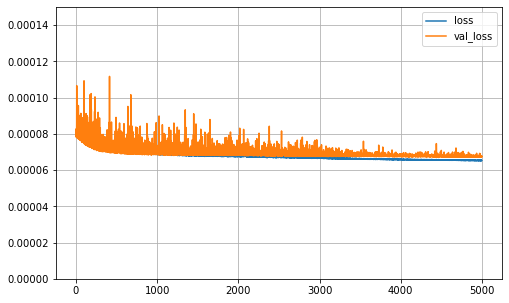

In [38]:
# Plot training history

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0000,0.00015)
plt.show()

#Export your training history for MSE
output = pd.DataFrame(history.history)
output.to_csv("mse_overtime.csv")